# Checking EIA923 data

This notebook explores the EIA923 data, 2009-2016, to identify whether the data and the standard metrics calculated from the data (e.g. heat rate and capacity factor) are plausible.
    * Calculate capacity factors
    * Calculate heat rates

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

In [2]:
pudl_engine = pudl.connect_db()

# Pull generation_fuel data from PUDL EIA923 tables
### Generation_fuel_eia923 gives info on heat rates, fuel consumed, & electricity generated

In [3]:
gf = pd.read_sql('''SELECT plant_id, report_date, fuel_type, aer_fuel_type, aer_fuel_category, \
                            fuel_consumed_total, fuel_consumed_for_electricity, fuel_mmbtu_per_unit, \
                            fuel_consumed_total_mmbtu, fuel_consumed_for_electricity_mmbtu, \
                            net_generation_mwh \
                            FROM generation_fuel_eia923''', pudl_engine)

In [4]:
pi = pd.read_sql('''SELECT plant_id, plant_state, nameplate_capacity_mw FROM plants_eia923''', pudl_engine)

In [5]:
p = pd.read_sql('''SELECT plant_id, plant_name FROM plants_eia''', pudl_engine)

In [6]:
gf = pd.merge(gf, pi, on='plant_id')
gf = pd.merge(gf, p, on='plant_id')

In [7]:
pd.to_datetime(pd.Series(gf.report_date))
gf.set_index(pd.DatetimeIndex(gf['report_date']), inplace=True)

In [8]:
gf = gf[(gf.plant_state == 'CO')]

In [9]:
n_plants = gf.plant_id.nunique()

In [10]:
# n_plants = 5

In [11]:
def cap_factor_plot(df, interval, title='', ylabel='', n=n_plants):
    
    """Plots capacity factors by plant for either 'M' (monthly) or 'A' (annual) intervals"""
    
    plants_sorted = df[['plant_id', 'nameplate_capacity_mw']].drop_duplicates(subset=['plant_id',]).sort_values(by='nameplate_capacity_mw', ascending=False)       
    df_byplant = df.groupby(['plant_id', pd.TimeGrouper(freq=interval)])
    capfac = (df_byplant.net_generation_mwh.sum()/(df_byplant.nameplate_capacity_mw.max()*730))
    fig, (ax) = plt.subplots(1, dpi=100)    
    fig.set_figwidth(10)    
    fig.set_figheight(6)
    
    if interval == 'M':
        z = 730 
    else:
        print('annual interval')
    if interval == 'A':
        z = 8760
    else:
        print('monthly interval')

    for plant_id in (plants_sorted.plant_id[:n]):     
        net_gen = df_byplant.net_generation_mwh.sum()[plant_id]
        cap = (df_byplant.nameplate_capacity_mw.max()*z)[plant_id]
        cap = net_gen/cap
        ax.plot(cap)
        ax.set_xlabel("Year")        
        ax.set_ylabel(ylabel)              
        ax.set_title(title+" for {} largest plants by capacity".format(n))               

monthly interval


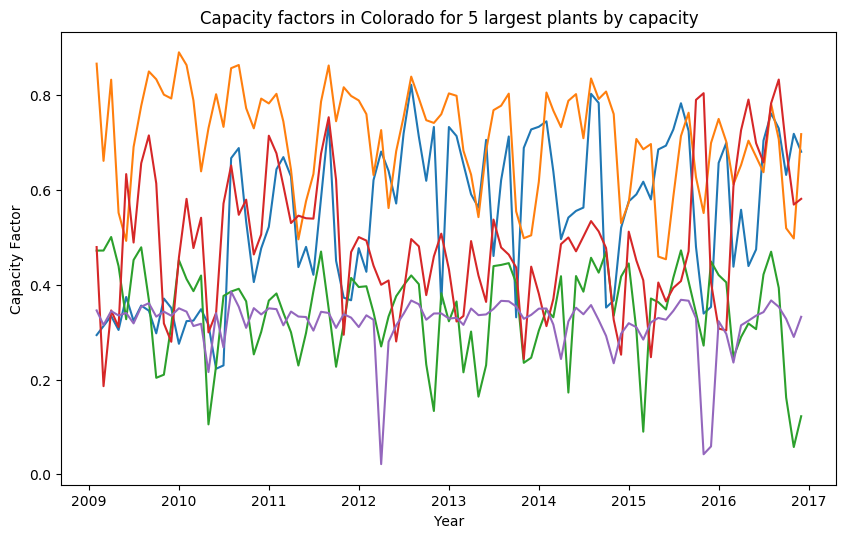

In [12]:
cap_factor_plot(gf, interval='M', n=5, ylabel='Capacity Factor', title='Capacity factors in Colorado')

In [13]:
def cap_factor_hist(df, b, interval, title='', ylabel='', n=n_plants):    
    
    """Plots capacity factors as a histogram with 'b' bins for either 'M' (monthly) or 'A' (annual) intervals"""

    df_byplant = df.groupby(['plant_id', pd.TimeGrouper(freq=interval)])
#     capfac = (df_byplant.net_generation_mwh.sum()/(df_byplant.nameplate_capacity_mw.max()*730))
    fig, (ax) = plt.subplots(1, dpi=100)    
#     capfac.plot(kind='hist')

    if interval == 'M':
        z = 730 
    else:
        print('annual interval')
    if interval == 'A':
        z = 8760
    else:
        print('monthly interval')
    
#     print(df_byplant.net_generation_mwh.sum())
    for plant_id in df_byplant.plant_id[:n]:   
        capfac = (df_byplant.net_generation_mwh.sum()/(df_byplant.nameplate_capacity_mw.max()*z))
        ax.set_xlabel("Capacity Factor")        
        ax.set_ylabel(ylabel)              
        ax.set_title(title+" capacity factors for {} largest plants by capacity".format(n))
        capfac.plot(kind='hist', bins=b, xlim=(0,2))

monthly interval


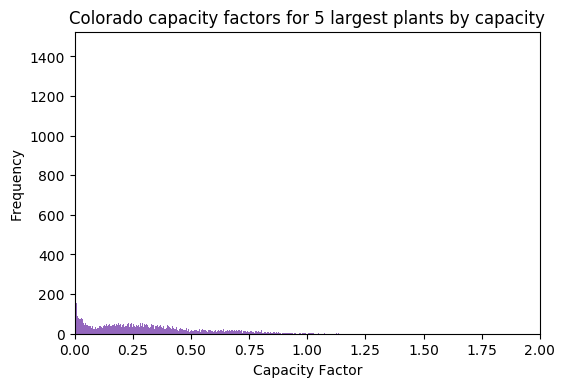

In [14]:
cap_factor_hist(gf, b=500, interval='M', title='Colorado', n=5)

In [15]:
def plot_byplant(df, coltoplot, i, title='', ylabel='', n=n_plants):
    
    """Plots any variable from generation_fuel table for either 'M' (monthly) or 'A' (annual) intervals"""

    plants_sorted = df[['plant_id','nameplate_capacity_mw']].drop_duplicates(subset=['plant_id',]).sort_values(by='nameplate_capacity_mw', ascending=False)    
    df_byplant = df.groupby(['plant_id', pd.TimeGrouper(freq=i)])        
    fig, axarr = plt.subplots(len(plants_sorted[:n]), dpi=100)
    fig.set_figwidth(10)    
    fig.set_figheight(6*len(plants_sorted[:n]))        
    for plant_id, ax in zip(plants_sorted.plant_id[:n], axarr):        
        ax.plot(df_byplant[coltoplot].sum()[plant_id], label=plant_id, lw=2)        
        ax.grid()        
        ax.set_xlabel("Year")        
        ax.set_ylabel(ylabel) 
        ax.set_title(title+" for Plant {}".format(plant_id))        
        legend = ax.legend()

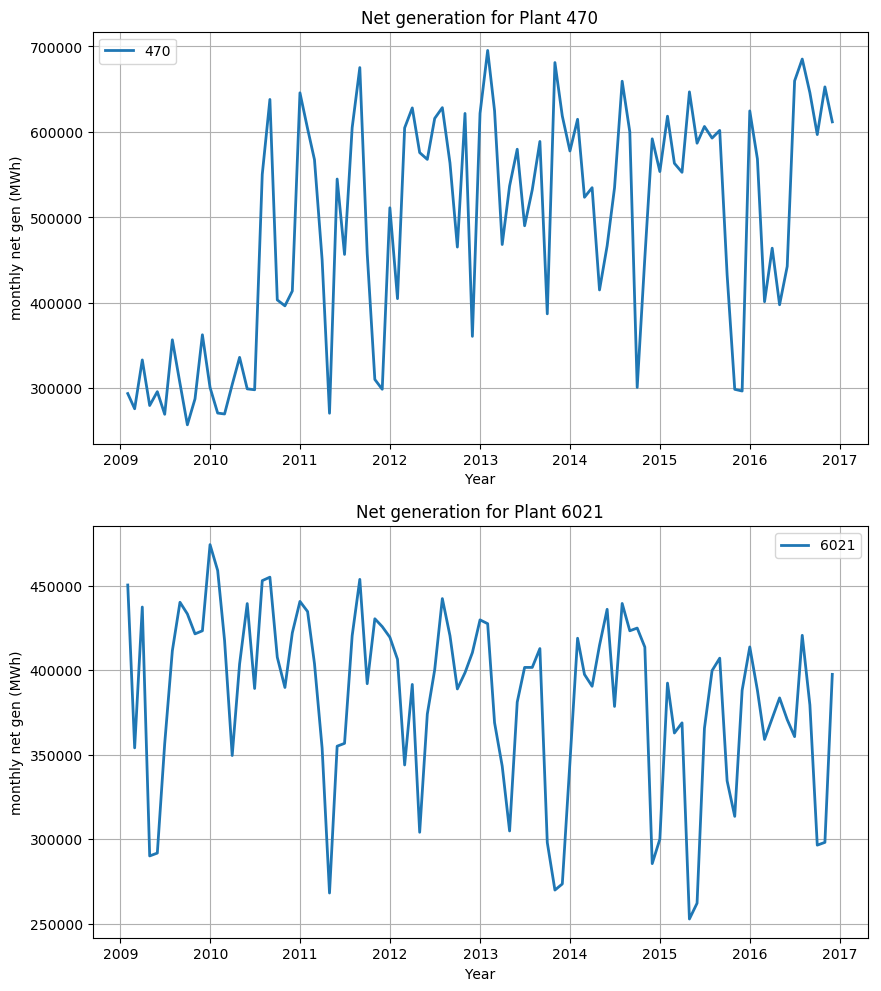

In [16]:
plot_byplant(gf, 'fuel_consumed_total', i='M', title='Net generation', ylabel='monthly net gen (MWh)', n=2)

## Heat rate calculations

Units of BTU per KWh are used

In [29]:
def heat_rate(df, i, title='', ylabel='', n=n_plants):
    
    """Plots heat rates by plant ID for either 'M' (monthly) or 'A' (annual) intervals"""

    
    plants_sorted = df[['plant_id','net_generation_mwh','fuel_consumed_total', 'fuel_consumed_for_electricity', 'nameplate_capacity_mw']].drop_duplicates(subset=['plant_id',]).sort_values(by='nameplate_capacity_mw', ascending=False)    
    df_byplant = df.groupby(['plant_id', pd.TimeGrouper(freq=i)])
    fig, (ax) = plt.subplots(1, dpi=100)    
    fig.set_figwidth(10)    
    
    
    for plant_id in plants_sorted.plant_id[:n]:   
        heat_rate_btu_per_kwh = \
        ((df_byplant['fuel_consumed_total_mmbtu'].sum()[plant_id]*1000000)/(df_byplant['net_generation_mwh'].sum()[plant_id]*1000))
        ax.plot(heat_rate_btu_per_kwh)
        ax.set_xlabel("Year")        
        ax.set_ylabel(ylabel) 
        ax.set_title(title+" for {} plants".format(n))        
#         legend = ax.legend(plants_sorted.plant_id)

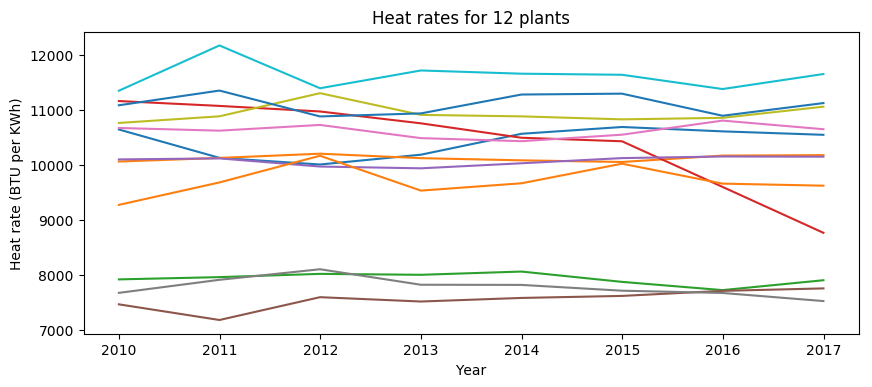

In [30]:
heat_rate(gf, n=12, i='A', title ='Heat rates', ylabel='Heat rate (BTU per KWh)')

In [ ]:
# # Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# # for each plant id
# gfa = gf[(gf.aer_fuel_category == 'coal')|(gf.aer_fuel_category == 'gas')]
# gfa = gfa.groupby(['plant_id', 'aer_fuel_category', pd.TimeGrouper(freq='A')])  

In [ ]:
# fuel_consumed_total_mmbtu_sum = gfa.fuel_consumed_total_mmbtu.sum()
# net_generation_mwh_sum = gfa.net_generation_mwh.sum()
# heat_rate_btu_per_kwh = (fuel_consumed_total_mmbtu_sum*1000000)/(net_generation_mwh_sum*1000)


In [ ]:
# # Need to figure out how to relabel x-axis
# heat_rate_btu_per_kwh.unstack(level=1).plot(kind='bar', stacked=True, ylim=(0, 100000))